## 공통: Import 및 로더/전처리 함수

In [39]:

import open3d as o3d
import numpy as np

def load_and_process_ply(path, scale=100.0, shift_x=0.0, rotate_deg_x=0.0):
    """
    PLY 파일을 로드하고, 스케일/이동/회전을 적용합니다.
    - scale: 좌표 단위 환산용 (예: m→mm 환산 전 임시 100배 등)
    - shift_x: X축 방향 평행이동
    - rotate_deg_x: X축 기준 회전 (deg)
    """
    mesh = o3d.io.read_triangle_mesh(path)
    if mesh.is_empty():
        raise ValueError(f"메쉬가 비어있습니다: {path}")
    mesh.compute_vertex_normals()
    mesh.scale(scale, center=(0, 0, 0))
    mesh.translate((shift_x, 0, 0))
    if rotate_deg_x != 0.0:
        radians = np.deg2rad(rotate_deg_x)
        R = mesh.get_rotation_matrix_from_axis_angle([radians, 0, 0])
        mesh.rotate(R, center=(0, 0, 0))
    return mesh


## 경로 / 변환 파라미터 설정

In [40]:

# 입력 PLY 경로
PATH1 = "../assets/ply/mesh_merged_imp_gpu_impeller_pred2.ply"  # 복원 메쉬
PATH2 = "../assets/ply/0807_normalized.ply"      # 원본 메쉬

# 공통 전처리 파라미터
SCALE      = 100.0      # 임시 스케일 (후에 mm 환산 복원)
SHIFT_X    = 6.95       # X축 평행이동 (필요 시 0.0으로)
ROT_X_DEG1 = 11.8       # 복원 메쉬의 X축 회전 (deg)
ROT_X_DEG2 = 0.0        # 원본 메쉬의 X축 회전 (deg)

# 로드 & 전처리
mesh1 = load_and_process_ply(PATH1, scale=SCALE, shift_x=SHIFT_X, rotate_deg_x=ROT_X_DEG1)
mesh2 = load_and_process_ply(PATH2, scale=SCALE, shift_x=0.0,     rotate_deg_x=ROT_X_DEG2)

print("메쉬 로드 완료:")
print(" - mesh1(복원) 삼각형:", np.asarray(mesh1.triangles).shape[0])
print(" - mesh2(원본)  삼각형:", np.asarray(mesh2.triangles).shape[0])


메쉬 로드 완료:
 - mesh1(복원) 삼각형: 132683
 - mesh2(원본)  삼각형: 1916


# 절대 위치 / 상대 위치 / 길이 측정

In [41]:
import numpy as np
import open3d as o3d

def _deg_from_rotmat(R):
    # 두 회전행렬 사이 각도(라디안→도)
    # (수치오차로 trace가 살짝 벗어날 수 있어 clip)
    t = np.clip((np.trace(R) - 1) / 2, -1.0, 1.0)
    return np.degrees(np.arccos(t))

def compute_absolute_position_accuracy(mesh1, mesh2, scale=SCALE):
    aabb1, aabb2 = mesh1.get_axis_aligned_bounding_box(), mesh2.get_axis_aligned_bounding_box()
    min_diff_mm = (aabb1.get_min_bound() - aabb2.get_min_bound()) / scale
    max_diff_mm = (aabb1.get_max_bound() - aabb2.get_max_bound()) / scale

    c1 = np.asarray(aabb1.get_center())
    c2 = np.asarray(aabb2.get_center())
    trans_vec_mm = (c1 - c2) / scale

    # 추가: 표 기준용 평균/최대 오차(축 기준)
    abs_mean_mm = np.mean(np.abs(trans_vec_mm))
    abs_max_mm  = np.max(np.abs(trans_vec_mm))

    # 기존: 축평균 RMS (참고용)
    trans_rmse_mm = np.sqrt(np.mean(trans_vec_mm**2))

    # 자세(참고)
    obb1, obb2 = mesh1.get_oriented_bounding_box(), mesh2.get_oriented_bounding_box()
    R1, R2 = obb1.R, obb2.R
    R_rel = R2.T @ R1
    rot_err_deg = _deg_from_rotmat(R_rel)

    return {
        "translation_vector_mm": trans_vec_mm,
        "translation_rmse_mm": trans_rmse_mm,
        "abs_mean_mm": abs_mean_mm,   # ▶ 절대 위치 평균오차(축 기준)
        "abs_max_mm":  abs_max_mm,    # ▶ 절대 위치 최대오차(축 기준)
        "aabb_min_diff_mm": min_diff_mm,
        "aabb_max_diff_mm": max_diff_mm,
        "rotation_error_deg": rot_err_deg
    }

def compute_relative_length_accuracy(mesh1, mesh2, scale=SCALE, use_obb=True):
    """
    상대 길이(크기) 정확도: 위치/자세 무시하고 '치수'만 비교
    - 기본: OBB의 세 변 길이 비교(회전 불변, 형상 자오선 기준)
    - 옵션: AABB 치수 비교(간단하지만 회전에 민감)
    """
    if use_obb:
        b1, b2 = mesh1.get_oriented_bounding_box(), mesh2.get_oriented_bounding_box()
        size1, size2 = b1.extent, b2.extent            # [Lx, Ly, Lz]
    else:
        b1, b2 = mesh1.get_axis_aligned_bounding_box(), mesh2.get_axis_aligned_bounding_box()
        size1, size2 = b1.get_extent(), b2.get_extent()

    size1_mm = size1 / scale
    size2_mm = size2 / scale
    diff_mm  = np.abs(size1_mm - size2_mm)

    # 면적 비교(동일 스케일 복원 규칙)
    area1_mm2 = mesh1.get_surface_area() / (scale * scale)
    area2_mm2 = mesh2.get_surface_area() / (scale * scale)

    out = {
        "size1_mm": size1_mm,            # [Lx, Ly, Lz]
        "size2_mm": size2_mm,
        "size_abs_diff_mm": diff_mm,     # per-axis |Δ|
        "area1_mm2": area1_mm2,
        "area2_mm2": area2_mm2
    }
    return out

def print_absolute_position_report(res_abs,
                                   thresh_mean_mm=0.10,  # 표: 평균 0.1mm
                                   thresh_max_mm=0.30):  # 표: 최대 0.3mm
    dx, dy, dz = res_abs["translation_vector_mm"]
    print("\n— 절대 위치 정확도 —")
    print(f"중심 오프셋 [mm]: dx={dx:.4f}, dy={dy:.4f}, dz={dz:.4f}")
    print(f"평균오차[mm](축기준): {res_abs['abs_mean_mm']:.4f} → {'o' if res_abs['abs_mean_mm']<=thresh_mean_mm else '❌'} (≤{thresh_mean_mm}mm)")
    print(f"최대오차[mm](축기준): {res_abs['abs_max_mm']:.4f} → {'o' if res_abs['abs_max_mm']<=thresh_max_mm else '❌'} (≤{thresh_max_mm}mm)")
    print(f"(참고) RMS[mm]: {res_abs['translation_rmse_mm']:.4f}")
    mn = res_abs["aabb_min_diff_mm"]; mx = res_abs["aabb_max_diff_mm"]
    print(f"AABB min 코너 차이[mm]: {mn[0]:.4f}, {mn[1]:.4f}, {mn[2]:.4f}")
    print(f"AABB max 코너 차이[mm]: {mx[0]:.4f}, {mx[1]:.4f}, {mx[2]:.4f}")

def compute_relative_position_accuracy_icp(mesh1, mesh2, scale=SCALE,
                                           n_points=20000, icp_thresh_mm=1.0):
    # 1) 메쉬 → 포인트샘플
    pcd1 = mesh1.sample_points_uniformly(number_of_points=n_points)  # ← fix
    pcd2 = mesh2.sample_points_uniformly(number_of_points=n_points)  # ← fix

    # 2) 초기 정렬: AABB 중심 일치
    T0 = np.eye(4)
    T0[:3, 3] = (mesh2.get_axis_aligned_bounding_box().get_center()
                 - mesh1.get_axis_aligned_bounding_box().get_center())
    pcd1.transform(T0)  # in-place

    # 3) ICP (point-to-point)
    threshold = icp_thresh_mm * scale
    result = o3d.pipelines.registration.registration_icp(
        pcd1, pcd2, threshold, np.eye(4),
        o3d.pipelines.registration.TransformationEstimationPointToPoint()
    )
    pcd1.transform(result.transformation)

    # 4) 정합 후 잔차 (양방향)
    d12 = np.asarray(pcd1.compute_point_cloud_distance(pcd2)) / scale  # mm
    d21 = np.asarray(pcd2.compute_point_cloud_distance(pcd1)) / scale  # mm
    d = np.concatenate([d12, d21])

    return {
        "rel_mean_mm": float(np.mean(d)),
        "rel_max_mm":  float(np.max(d)),
    }

def print_relative_length_report(res_len, threshold_len_mm=0.05, label="(OBB 치수)"):
    d = res_len["size_abs_diff_mm"]
    print("\n— 상대 길이(크기) 정확도 —", label)
    print(f"크기1 [mm] : {res_len['size1_mm'][0]:.3f}, {res_len['size1_mm'][1]:.3f}, {res_len['size1_mm'][2]:.3f}")
    print(f"크기2 [mm] : {res_len['size2_mm'][0]:.3f}, {res_len['size2_mm'][1]:.3f}, {res_len['size2_mm'][2]:.3f}")
    print(f"|Δ|   [mm] : {d[0]:.4f}, {d[1]:.4f}, {d[2]:.4f}")
    marks = ["o" if x <= threshold_len_mm else "❌" for x in d]
    print(f"축별 기준(±{threshold_len_mm}mm): {' '.join(marks)}")
    print(f"면적 비교  : A={res_len['area1_mm2']:.3f} mm² / B={res_len['area2_mm2']:.3f} mm²")

def print_relative_position_report(res_rel, mean_thr=0.05, max_thr=0.10):
    print("\n— 상대 위치 정확도(정합 후 잔차) —")
    m, M = res_rel["rel_mean_mm"], res_rel["rel_max_mm"]
    print(f"평균오차[mm]: {m:.4f} → {'o' if m<=mean_thr else '❌'} (≤{mean_thr}mm)")
    print(f"최대오차[mm]: {M:.4f} → {'o' if M<=max_thr else '❌'} (≤{max_thr}mm)")


In [42]:


res_abs = compute_absolute_position_accuracy(mesh1, mesh2, scale=SCALE)
print_absolute_position_report(res_abs, thresh_mean_mm=0.10, thresh_max_mm=0.30)  # 표 기준

res_rel = compute_relative_position_accuracy_icp(mesh1, mesh2, scale=SCALE, n_points=20000, icp_thresh_mm=1.0)
print_relative_position_report(res_rel, mean_thr=0.05, max_thr=0.10)               # 표 기준

res_len_obb  = compute_relative_length_accuracy(mesh1, mesh2, scale=SCALE, use_obb=True)
print_relative_length_report(res_len_obb,  threshold_len_mm=0.05, label="(OBB 치수)")


— 절대 위치 정확도 —
중심 오프셋 [mm]: dx=-0.0004, dy=-0.0003, dz=0.0000
평균오차[mm](축기준): 0.0002 → o (≤0.1mm)
최대오차[mm](축기준): 0.0004 → o (≤0.3mm)
(참고) RMS[mm]: 0.0003
AABB min 코너 차이[mm]: -0.0014, 0.0001, 0.0003
AABB max 코너 차이[mm]: 0.0006, -0.0006, -0.0003

— 상대 위치 정확도(정합 후 잔차) —
평균오차[mm]: 0.0072 → o (≤0.05mm)
최대오차[mm]: 0.0299 → o (≤0.1mm)

— 상대 길이(크기) 정확도 — (OBB 치수)
크기1 [mm] : 0.995, 0.999, 0.460
크기2 [mm] : 1.000, 1.000, 0.455
|Δ|   [mm] : 0.0057, 0.0007, 0.0058
축별 기준(±0.05mm): o o o
면적 비교  : A=4.059 mm² / B=3.900 mm²


# 기하학적 정확도

In [43]:

def compute_rmse_distance(mesh1, mesh2, n_points=10000):
    pcd1 = mesh1.sample_points_uniformly(number_of_points=n_points)
    pcd2 = mesh2.sample_points_uniformly(number_of_points=n_points)
    d1 = np.asarray(pcd1.compute_point_cloud_distance(pcd2))
    d2 = np.asarray(pcd2.compute_point_cloud_distance(pcd1))
    rmse = np.sqrt((np.mean(d1 ** 2) + np.mean(d2 ** 2)) / 2)
    return rmse

def compute_geometric_accuracy(mesh1, mesh2, n_points=10000):
    pcd1 = mesh1.sample_points_uniformly(number_of_points=n_points)
    pcd2 = mesh2.sample_points_uniformly(number_of_points=n_points)
    d1 = np.asarray(pcd1.compute_point_cloud_distance(pcd2))
    d2 = np.asarray(pcd2.compute_point_cloud_distance(pcd1))
    chamfer = (np.mean(d1) + np.mean(d2)) / 2
    hausdorff = max(np.max(d1), np.max(d2))
    return chamfer, hausdorff

rmse = compute_rmse_distance(mesh1, mesh2)
chamfer, hausdorff = compute_geometric_accuracy(mesh1, mesh2)

# 스케일 복원 (길이계열 → ÷SCALE)
rmse_mm      = rmse / SCALE
chamfer_mm   = chamfer / SCALE
hausdorff_mm = hausdorff / SCALE

print("— 기하학적 정확도 —")
print(f"RMSE              : {rmse_mm:.4f} mm")
print(f"Chamfer Distance  : {chamfer_mm:.4f} mm → {'o 기준 만족' if chamfer_mm <= 0.1 else '❌ 기준 초과'}")
print(f"Hausdorff Distance: {hausdorff_mm:.4f} mm → {'o 기준 만족' if hausdorff_mm <= 0.2 else '❌ 기준 초과'}")


— 기하학적 정확도 —
RMSE              : 0.0113 mm
Chamfer Distance  : 0.0102 mm → o 기준 만족
Hausdorff Distance: 0.0379 mm → o 기준 만족


# 표면 일치도

In [44]:

def compute_surface_matching_accuracy(source_mesh, target_mesh, n_points=10000):
    pcd_s = source_mesh.sample_points_uniformly(number_of_points=n_points)
    pcd_t = target_mesh.sample_points_uniformly(number_of_points=n_points)
    d = np.asarray(pcd_s.compute_point_cloud_distance(pcd_t))
    mean_error = np.mean(d)
    max_error  = np.max(d)
    return mean_error, max_error

mean_surface, max_surface = compute_surface_matching_accuracy(mesh1, mesh2)
mean_surface_mm = mean_surface / SCALE
max_surface_mm  = max_surface  / SCALE

print("— 표면 일치도 —")
print(f"평균 오차: {mean_surface_mm:.4f} mm (참고용)")
print(f"최대 오차: {max_surface_mm:.4f} mm → {'o' if max_surface_mm <= 0.1 else '❌'}")


— 표면 일치도 —
평균 오차: 0.0101 mm (참고용)
최대 오차: 0.0334 mm → o


# 특정특징 정확도

In [57]:
# %% [markdown]
# # x=0 평면 단면(YZ 투영) 추출

# %%
import os
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt

# 이미 위에서 정의된 것들 재사용 (PATH1/2, SCALE, SHIFT_X, ROT_X_DEG1/2, load_and_process_ply, mesh1/mesh2)
# 여기서는 mesh1, mesh2가 존재한다고 가정

# 단면 파라미터
X_PLANE_VALUE_MM = 0.0        # x=0 평면 (mm 기준)
SLICE_THICKNESS_MM = 0.5      # ± thickness/2 (mm)
N_SAMPLE = 300_000            # 표면 샘플 포인트 수 (충분히 크게)

# 저장 경로
OUT_DIR = "../out/sections"
os.makedirs(OUT_DIR, exist_ok=True)

print("SCALE =", SCALE)


SCALE = 100.0


In [58]:
# %%
def sample_points_from_mesh(mesh, n=N_SAMPLE):
    """메쉬 표면 포인트 균일 샘플링"""
    return mesh.sample_points_uniformly(number_of_points=int(n))

def slice_by_plane_X(points_xyz, x0, thickness_mm, scale):
    """
    x = x0 (mm) 평면 주변 두께(±thickness/2)로 슬라이스.
    내부 좌표가 mm×SCALE라면, mm → 내부단위 변환해서 마스크 생성.
    """
    # 내부 좌표 단위에서의 평면/두께
    x0_internal = x0 * scale
    half_band_internal = (thickness_mm * scale) / 2.0
    x = points_xyz[:, 0]
    mask = np.abs(x - x0_internal) <= half_band_internal
    return mask

def project_to_yz(points_xyz, scale):
    """
    3D 포인트(mm×SCALE)를 YZ 평면 2D(mm)로 투영.
    (y,z)만 뽑고 SCALE로 나눠 mm로 환산.
    """
    yz = points_xyz[:, 1:3] / scale
    return yz

def plot_section(yz, title, save_path=None, s=1.0):
    if yz.size == 0:
        print("[경고] 표시할 포인트가 없습니다.")
        return
    plt.figure(figsize=(6,6))
    plt.scatter(yz[:,0], yz[:,1], s=s)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title(title)
    plt.xlabel("Y [mm]"); plt.ylabel("Z [mm]")
    plt.grid(True, alpha=0.2)
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"[저장] {save_path}")
    plt.show()

def save_points(yz, path_csv):
    if yz.size == 0:
        print("[정보] 비어있는 단면이라 저장을 건너뜁니다.")
        return
    np.savetxt(path_csv, yz, fmt="%.6f", delimiter=",")
    print(f"[저장] {path_csv}  (columns: Y_mm,Z_mm)")


In [59]:
# %%
pcd1 = sample_points_from_mesh(mesh1, N_SAMPLE)
pcd2 = sample_points_from_mesh(mesh2, N_SAMPLE)

pts1 = np.asarray(pcd1.points)  # 내부단위 (mm×SCALE 가정)
pts2 = np.asarray(pcd2.points)

print("샘플 포인트수:",
      "mesh1:", pts1.shape[0],
      "mesh2:", pts2.shape[0])


샘플 포인트수: mesh1: 300000 mesh2: 300000


In [60]:
# %%
mask1 = slice_by_plane_X(pts1, x0=X_PLANE_VALUE_MM, thickness_mm=SLICE_THICKNESS_MM, scale=SCALE)
mask2 = slice_by_plane_X(pts2, x0=X_PLANE_VALUE_MM, thickness_mm=SLICE_THICKNESS_MM, scale=SCALE)

sec1_yz = project_to_yz(pts1[mask1], scale=SCALE)
sec2_yz = project_to_yz(pts2[mask2], scale=SCALE)

print(f"mesh1 단면점: {sec1_yz.shape[0]}  |  mesh2 단면점: {sec2_yz.shape[0]}")
if sec1_yz.size == 0 or sec2_yz.size == 0:
    print("[주의] 단면 포인트가 너무 적거나 없음. SLICE_THICKNESS_MM를 키워보세요 (예: 1.0~2.0 mm).")


mesh1 단면점: 279847  |  mesh2 단면점: 279185


c:\Users\user\anaconda3\envs\point2cad\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning:

Glyph 45800 missing from current font.

c:\Users\user\anaconda3\envs\point2cad\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning:

Glyph 47732 missing from current font.

c:\Users\user\anaconda3\envs\point2cad\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning:

Glyph 45800 missing from current font.

c:\Users\user\anaconda3\envs\point2cad\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning:

Glyph 47732 missing from current font.



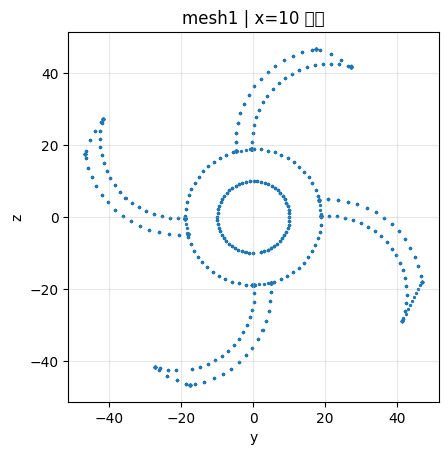

[mesh2] 첫 유효 단면 x = 27.000  (points = 367)


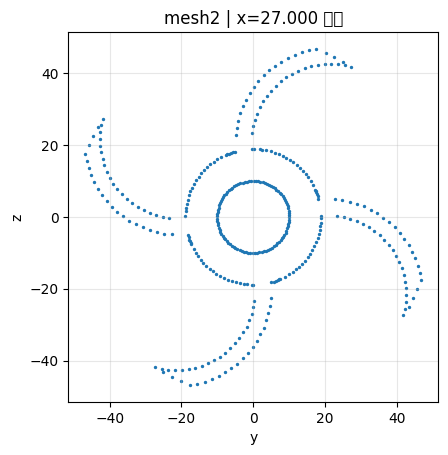

In [61]:
# mesh1, mesh2 → numpy 포인트
pts1 = mesh1 if isinstance(mesh1, np.ndarray) else np.asarray(mesh1.vertices)
pts2 = mesh2 if isinstance(mesh2, np.ndarray) else np.asarray(mesh2.vertices)
(y1, z1), idx1 = slice_x_to_yz(pts1, x_value=20.0, thickness=1)
plot_yz(y1, z1, title="mesh1 | x=10 단면")
# mesh2: x=10~30 스캔하여 첫 유효 단면 찾기
x_hit, (y2, z2), idx2 = find_first_nonempty_slice(
    pts2, x_start=10.0, x_stop=30.0, step=0.5, thickness=1
)

if x_hit is not None:
    print(f"[mesh2] 첫 유효 단면 x = {x_hit:.3f}  (points = {len(y2)})")
    plot_yz(y2, z2, title=f"mesh2 | x={x_hit:.3f} 단면")
else:
    print("[mesh2] x=10~30 범위에서 유효 단면을 찾지 못했습니다. step/두께를 늘려보세요.")

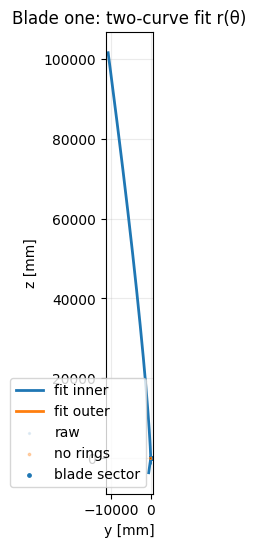

중심 (y0,z0) = (0.038486, -0.212593)
θ 범위 (rad) = (-1.710423, -1.466077)  / (deg) = (-98.0, -84.0)

[흡입/내측 곡선]  r_in(θ) = -1.95546e+09·θ^5 + -1.57951e+10·θ^4 + -5.10181e+10·θ^3 + -8.23687e+10·θ^2 + -6.64719e+10·θ + -2.14508e+10
[압력/외측 곡선]  r_out(θ) = 3.30161e+06·θ^5 + 2.61902e+07·θ^4 + 8.30567e+07·θ^3 + 1.31626e+08·θ^2 + 1.04242e+08·θ + 3.30039e+07

Cartesian param:
  y(θ) = y0 + r(θ)·cosθ
  z(θ) = z0 + r(θ)·sinθ   (θ는 위 범위에서 사용)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ---------- 0) 유틸 ----------
def circle_from_3pts(p1, p2, p3, eps=1e-12):
    x1,y1 = p1; x2,y2 = p2; x3,y3 = p3
    A = np.array([[2*(x2-x1), 2*(y2-y1)],
                  [2*(x3-x1), 2*(y3-y1)]], float)
    b = np.array([x2*x2+y2*y2 - x1*x1-y1*y1,
                  x3*x3+y3*y3 - x1*x1-y1*y1], float)
    if abs(np.linalg.det(A)) < eps: 
        return None
    c = np.linalg.solve(A, b)      # center
    r = np.linalg.norm([x1 - c[0], y1 - c[1]])
    return c, float(r)

def ransac_circle(P, n_iter=6000, tol=0.6, rng=None):
    """P: (N,2) / tol: 반경 오차 허용(mm)"""
    if rng is None: rng = np.random.default_rng(0)
    N = len(P)
    if N < 8: return None
    best = None; best_in = -1
    for _ in range(int(n_iter)):
        i,j,k = rng.choice(N, size=3, replace=False)
        res = circle_from_3pts(P[i], P[j], P[k])
        if res is None: 
            continue
        c, r = res
        d = np.abs(np.linalg.norm(P - c, axis=1) - r)
        mask = d <= tol
        n_in = int(mask.sum())
        if n_in > best_in:
            best_in = n_in
            best = (c, r, mask)
    return best  # (center(2,), radius, inlier_mask) or None

def kmeans1d(r, k=2, iters=40):
    """간단 1D k-means (반경값 분리용)"""
    r = np.asarray(r).reshape(-1,1)
    # 초기 중심: 분위수
    qs = np.linspace(0,1,k+2)[1:-1]
    C = np.quantile(r, qs).reshape(k,1)
    for _ in range(iters):
        # 할당
        D = np.abs(r - C.T)              # (N,k)
        lab = D.argmin(axis=1)
        # 업데이트
        newC = np.array([r[lab==i].mean() if np.any(lab==i) else C[i] for i in range(k)]).reshape(k,1)
        if np.allclose(newC, C): break
        C = newC
    return lab, C.ravel()

# ---------- 1) 링(원통) 제거 ----------
def remove_rings(y, z, inner_first=True, tol=0.6, n_iter=6000):
    P = np.column_stack([y, z])
    # 1) 바깥 링
    out_fit = ransac_circle(P, n_iter=n_iter, tol=tol)
    masks = []
    circles = []
    if out_fit is not None:
        c, r, m = out_fit
        masks.append(m); circles.append((c, r))
        P = P[~m]
    # 2) 안쪽 링 (잔여 점에서 다시)
    in_fit = ransac_circle(P, n_iter=n_iter, tol=tol)
    if in_fit is not None:
        c2, r2, m2 = in_fit
        masks.append(m2); circles.append((c2, r2))
        P = P[~m2]
    # 결과
    kept = np.column_stack([y, z])
    for fit in [out_fit, in_fit]:
        if fit is None: 
            continue
        _, r, m = fit
        # (원래 전체 좌표 기준으로) 반경거리 기반 제거
    # 단순화: 이미 위에서 제거된 P가 잔여 → 그대로 반환
    remain = P
    # 중심은 두 원의 중심 평균(하나만 있으면 그 중심)
    if circles:
        c_all = np.vstack([c for c,_ in circles]).mean(axis=0)
    else:
        c_all = np.array([np.mean(y), np.mean(z)])
    return remain[:,0], remain[:,1], c_all, circles  # y_rem, z_rem, center, [(c,r),...]

# ---------- 2) 블레이드 1개 자동 선택(각도 섹터) ----------
def pick_blade_sector(y, z, center, bin_deg=2, min_count=8, pad_deg=6):
    yc, zc = center
    th = np.degrees(np.arctan2(z - zc, y - yc))  # [-180,180]
    bins = np.arange(-180, 180+bin_deg, bin_deg)
    hist, edges = np.histogram(th, bins=bins)
    # 연속 구간들 찾기
    active = hist >= min_count
    # 라운드-로빈(원형) 처리
    active = active.astype(int)
    # 구간 인덱스 목록 만들기
    segs = []
    i = 0
    while i < len(active):
        if active[i]:
            j = i
            while j < len(active) and active[j]:
                j += 1
            segs.append((i, j-1))
            i = j
        else:
            i += 1
    if not segs:
        # 전부 얇다면 가장 큰 빈 선택
        i = np.argmax(hist); segs=[(i,i)]
    # 가장 길거나 카운트 큰 구간 선택
    best = max(segs, key=lambda ij: hist[ij[0]:ij[1]+1].sum())
    th_min = edges[best[0]] - pad_deg
    th_max = edges[best[1]+1] + pad_deg
    # 섹터 마스크
    mask = (th >= th_min) & (th <= th_max)
    return mask, np.radians([th_min, th_max]), th  # 라디안 범위

# ---------- 3) 섹터 내 두 곡선 분리 + 다항식 피팅 ----------
def fit_blade_two_curves(y, z, center, theta_range_rad, deg=5):
    yc, zc = center
    theta = np.arctan2(z - zc, y - yc)     # 라디안
    r     = np.hypot(y - yc, z - zc)

    th_min, th_max = theta_range_rad
    # θ를 [th_min, th_max]로 래핑
    def wrap(t):
        # 범위를 넘는 각도는 2π 더하거나 빼서 구간 안으로
        tw = t.copy()
        while np.any(tw < th_min): tw[tw < th_min] += 2*np.pi
        while np.any(tw > th_max): tw[tw > th_max] -= 2*np.pi
        return tw
    theta_w = wrap(theta)

    # 1D k-means로 반경을 두 그룹으로 → 내/외 곡선
    labels, centers = kmeans1d(r, k=2)
    inner_id = np.argmin(centers); outer_id = 1 - inner_id
    th_in, r_in   = theta_w[labels==inner_id], r[labels==inner_id]
    th_out, r_out = theta_w[labels==outer_id], r[labels==outer_id]

    # θ 기준 정렬
    ord_in  = np.argsort(th_in);   th_in,  r_in  = th_in[ord_in],  r_in[ord_in]
    ord_out = np.argsort(th_out);  th_out, r_out = th_out[ord_out], r_out[ord_out]

    # 다항식 r(θ) 피팅 (라디안 입력)
    cin  = np.polyfit(th_in,  r_in,  deg)
    cout = np.polyfit(th_out, r_out, deg)

    # 평가 함수
    p_in  = np.poly1d(cin)
    p_out = np.poly1d(cout)

    return {
        "theta_range": (th_min, th_max),
        "coeff_inner": cin,  # 높은 차수부터
        "coeff_outer": cout,
        "eval_inner": p_in,
        "eval_outer": p_out,
        "data": {
            "theta_in": th_in, "r_in": r_in,
            "theta_out": th_out, "r_out": r_out
        },
        "center": (yc, zc)
    }

# ---------- 4) 전체 파이프라인 래퍼 + 시각화 ----------
def extract_blade_equations(y, z,
                            ring_tol=0.6, ransac_iter=6000,
                            bin_deg=2, min_count=8, pad_deg=6,
                            poly_deg=5, plot=True):
    # (1) 링 제거
    yR, zR, center, circles = remove_rings(y, z, tol=ring_tol, n_iter=ransac_iter)

    # (2) 블레이드 섹터 자동 선택
    mask, (th_min, th_max), theta_all = pick_blade_sector(yR, zR, center,
                                                          bin_deg=bin_deg,
                                                          min_count=min_count,
                                                          pad_deg=pad_deg)
    yB, zB = yR[mask], zR[mask]

    # (3) 두 곡선 피팅
    fit = fit_blade_two_curves(yB, zB, center, (th_min, th_max), deg=poly_deg)

    if plot:
        # 데이터 + 적합 곡선 오버레이
        yc, zc = center
        ths = np.linspace(th_min, th_max, 400)
        rin  = fit["eval_inner"](ths)
        rout = fit["eval_outer"](ths)
        yin  = yc + rin * np.cos(ths); zin  = zc + rin * np.sin(ths)
        yout = yc + rout* np.cos(ths); zout = zc + rout* np.sin(ths)

        plt.figure(figsize=(6,6))
        plt.scatter(y, z, s=2, alpha=0.1, label="raw")
        plt.scatter(yR, zR, s=3, alpha=0.3, label="no rings")
        plt.scatter(yB, zB, s=6, c='tab:blue', label="blade sector")
        plt.plot(yin,  zin,  lw=2, label="fit inner")
        plt.plot(yout, zout, lw=2, label="fit outer")
        for c,r in circles:
            ang=np.linspace(0,2*np.pi,200)
            plt.plot(c[0]+r*np.cos(ang), c[1]+r*np.sin(ang), 'k--', lw=0.8, alpha=0.5)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.xlabel("y [mm]"); plt.ylabel("z [mm]")
        plt.title("Blade one: two-curve fit r(θ)")
        plt.grid(True, alpha=0.25); plt.legend()
        plt.show()

    # 방정식 출력(사람 읽기용)
    cin, cout = fit["coeff_inner"], fit["coeff_outer"]
    def poly_to_str(c):
        terms=[]
        n=len(c)-1
        for i,a in enumerate(c):
            p=n-i
            if abs(a)<1e-10: continue
            if p==0: terms.append(f"{a:.6g}")
            elif p==1: terms.append(f"{a:.6g}·θ")
            else: terms.append(f"{a:.6g}·θ^{p}")
        return " + ".join(terms) if terms else "0"
    print("중심 (y0,z0) =", tuple(np.round(fit["center"], 6)))
    print("θ 범위 (rad) =", tuple(np.round(fit["theta_range"], 6)),
          " / (deg) =", tuple(np.round(np.degrees(fit["theta_range"]), 3)))
    print("\n[흡입/내측 곡선]  r_in(θ) =", poly_to_str(cin))
    print("[압력/외측 곡선]  r_out(θ) =", poly_to_str(cout))
    print("\nCartesian param:")
    print("  y(θ) = y0 + r(θ)·cosθ")
    print("  z(θ) = z0 + r(θ)·sinθ   (θ는 위 범위에서 사용)")

    return fit

# ---------------- 사용 예 ----------------
# y1, z1 는 당신이 만든 x=10 단면의 mesh1 데이터
fit_result1 = extract_blade_equations(y1, z1,
                                     ring_tol=0.8,   # 링 포인트 허용오차(mm) 상황에 맞게 0.4~1.2
                                     ransac_iter=8000,
                                     bin_deg=2, min_count=10, pad_deg=6,
                                     poly_deg=5, plot=True)




# 부피 및 치수 정확도

In [54]:
# %% [markdown]
# # 치수 기반 근사 부피 계산 (mesh1, mesh2)

# %%
import numpy as np
import open3d as o3d
import math

# ---------- 부피 공식들 (단위: mm 입력 → mm^3 출력) ----------
def vol_cylinder(Do_mm, H_mm):
    r = Do_mm * 0.5
    return math.pi * r * r * H_mm

def vol_hollow_cylinder(Do_mm, Di_mm, H_mm):
    ro, ri = Do_mm*0.5, Di_mm*0.5
    return math.pi * (ro*ro - ri*ri) * H_mm

def vol_frustum(Db_mm, Dt_mm, H_mm):  # 원뿔대(밑면/윗면 지름 Db, Dt)
    Rb, Rt = Db_mm*0.5, Dt_mm*0.5
    return (math.pi * H_mm / 3.0) * (Rb*Rb + Rb*Rt + Rt*Rt)

def vol_hollow_frustum(Dob_mm, Dot_mm, Dib_mm, Dit_mm, H_mm):
    return vol_frustum(Dob_mm, Dot_mm, H_mm) - vol_frustum(Dib_mm, Dit_mm, H_mm)

# ---------- 치수 추정 유틸 ----------
def _axis_index(axis):
    return {'x':0, 'y':1, 'z':2}[axis]

def estimate_dims_from_mesh(mesh, scale=1.0, axis='z',
                            use_obb=True,
                            find_inner=True,
                            slice_thickness_mm=1.0,
                            n_points=200_000,
                            ransac_iter=6000,
                            inlier_tol_mm=0.05):
    """
    외경/높이: OBB(or AABB)로 추정
    내경: 축 중앙 x=0/y=0/z=0 단면에서 RANSAC 원 피팅 (있으면)
    반환: dict {Do_mm, H_mm, Di_mm(optional), center_mm}
    """
    # 1) 외경/높이 (OBB 또는 AABB)
    box = mesh.get_oriented_bounding_box() if use_obb else mesh.get_axis_aligned_bounding_box()
    ext = np.array(box.extent) / scale  # mm
    idx = _axis_index(axis)
    H_mm = float(ext[idx])
    # 축 수직 평면의 두 변 중 더 큰 쪽을 외경으로 사용
    Do_mm = float(max(ext[(idx+1)%3], ext[(idx+2)%3]))
    center_mm = np.array(box.get_center()) / scale

    result = dict(Do_mm=Do_mm, H_mm=H_mm, center_mm=center_mm, Di_mm=None)

    if not find_inner:
        return result

    # 2) 내경: 축 중앙 단면 슬라이스 → 2D 투영 → RANSAC 원
    # 샘플링
    pcd = mesh.sample_points_uniformly(number_of_points=int(n_points))
    pts = np.asarray(pcd.points)
    # 슬라이스 (중앙값 기준)
    c = float(center_mm[idx])                 # mm
    c_int = c * scale                         # 내부 단위
    half_band = (slice_thickness_mm * scale) / 2.0
    mask = np.abs(pts[:, idx] - c_int) <= half_band
    slice3d = pts[mask]
    if slice3d.size == 0:
        return result

    # 축 수직 평면으로 투영 (지정 축 제외 나머지 2축)
    axes2d = [a for a in range(3) if a != idx]
    P2 = slice3d[:, axes2d] / scale  # mm

    # RANSAC 원 피팅 (간단 버전)
    rng = np.random.default_rng(0)
    best = None; best_in = -1
    N = len(P2)
    if N >= 12:
        for _ in range(int(ransac_iter)):
            i,j,k = rng.choice(N, size=3, replace=False)
            p1,p2,p3 = P2[i], P2[j], P2[k]
            A = np.array([[2*(p2[0]-p1[0]), 2*(p2[1]-p1[1])],
                          [2*(p3[0]-p1[0]), 2*(p3[1]-p1[1])]], dtype=float)
            b = np.array([p2[0]**2 + p2[1]**2 - p1[0]**2 - p1[1]**2,
                          p3[0]**2 + p3[1]**2 - p1[0]**2 - p1[1]**2], dtype=float)
            if abs(np.linalg.det(A)) < 1e-12:
                continue
            ctr = np.linalg.solve(A, b)
            r   = np.linalg.norm(p1 - ctr)
            d   = np.abs(np.linalg.norm(P2 - ctr, axis=1) - r)
            mask_in = d <= inlier_tol_mm
            n_in = int(mask_in.sum())
            if n_in > best_in:
                best_in = n_in
                best = (ctr, r)

    if best is not None and best_in >= 20:
        Di_mm = float(2.0 * best[1])
        result["Di_mm"] = Di_mm

    return result

# ---------- mesh1/mesh2 치수 추정 + 부피 계산 ----------
def report_volume_from_dims(name, mesh, scale, axis='z',
                            use_obb=True, find_inner=True,
                            slice_thickness_mm=1.0,
                            solid_or_hollow="auto"):
    dims = estimate_dims_from_mesh(mesh, scale=scale, axis=axis,
                                   use_obb=use_obb, find_inner=find_inner,
                                   slice_thickness_mm=slice_thickness_mm)
    Do, H, Di = dims["Do_mm"], dims["H_mm"], dims["Di_mm"]
    print(f"\n[{name}]  (axis={axis}, OBB={'Y' if use_obb else 'N'})")
    print(f"  외경 Do = {Do:.3f} mm")
    print(f"  높이  H  = {H:.3f} mm")
    if Di is not None:
        print(f"  내경 Di = {Di:.3f} mm (단면 RANSAC)")
    else:
        print("  내경 Di = (탐지 실패 또는 없음)")

    # 자동 판단: 내경이 있으면 중공원통, 없으면 원통
    mode = solid_or_hollow
    if mode == "auto":
        mode = "hollow" if (Di is not None and Di > 0 and Di < Do) else "solid"

    if mode == "hollow" and Di is not None:
        V = vol_hollow_cylinder(Do, Di, H)
        print(f"  ▶ 중공원통 부피 ≈ {V:.3f} mm³  (= {V/1000:.3f} cm³)")
    else:
        V = vol_cylinder(Do, H)
        print(f"  ▶ 원통 부피 ≈ {V:.3f} mm³  (= {V/1000:.3f} cm³)")

    return dict(Do_mm=Do, H_mm=H, Di_mm=Di, volume_mm3=V)

# 실행 예 (mesh1/mesh2는 이미 로드되어 있다고 가정)
res1 = report_volume_from_dims("mesh1(복원)", mesh1, scale=SCALE, axis='z',
                               use_obb=True, find_inner=True,
                               slice_thickness_mm=1.0)
res2 = report_volume_from_dims("mesh2(원본)", mesh2, scale=SCALE, axis='z',
                               use_obb=True, find_inner=True,
                               slice_thickness_mm=1.0)



[mesh1(복원)]  (axis=z, OBB=Y)
  외경 Do = 0.999 mm
  높이  H  = 0.460 mm
  내경 Di = 9.796 mm (단면 RANSAC)
  ▶ 원통 부피 ≈ 0.361 mm³  (= 0.000 cm³)

[mesh2(원본)]  (axis=z, OBB=Y)
  외경 Do = 1.000 mm
  높이  H  = 0.455 mm
  내경 Di = 14.095 mm (단면 RANSAC)
  ▶ 원통 부피 ≈ 0.357 mm³  (= 0.000 cm³)


In [55]:
def check_volume_diff(res1, res2, mode="ref_mesh2", eps=1e-12):
    """
    res1/res2: report_volume_from_dims(...)의 반환 dict (volume_mm3 포함)
    mode:
      - "ref_mesh2": |V1-V2| / V2 * 100  (원본 기준)
      - "max":       |V1-V2| / max(V1,V2) * 100 (대칭·보수적)
      - "avg":       |V1-V2| / ((V1+V2)/2) * 100 (대칭·평균기준)
    """
    V1 = float(res1["volume_mm3"])
    V2 = float(res2["volume_mm3"])

    if mode == "max":
        denom = max(V1, V2, eps)
    elif mode == "avg":
        denom = max(0.5*(V1 + V2), eps)
    else:  # "ref_mesh2"
        denom = max(V2, eps)

    diff_pct = abs(V1 - V2) / denom * 100.0
    diff_pct = diff_pct / SCALE  # mm³ → mm³ (스케일 복원)
    print(f"[부피 비교] V1={V1:.3f} mm³, V2={V2:.3f} mm³, Δ%={diff_pct:.4f}% (mode={mode})")
    print("결론:", "❌ 1% 이상 차이" if diff_pct >= 1.0 else "✅ 1% 미만")
    return diff_pct

# 사용 예 (직전에 구한 res1, res2 그대로 사용)
check_volume_diff(res1, res2, mode="ref_mesh2")  # 기본: 원본(mesh2) 기준

[부피 비교] V1=0.361 mm³, V2=0.357 mm³, Δ%=0.0105% (mode=ref_mesh2)
결론: ✅ 1% 미만


0.010540284749049979

# 형상 편차 시각화

In [56]:
import plotly.graph_objects as go

def visualize_o3d_mesh(title, mesh):
    # open3d mesh의 vertex/face 추출
    vertices = np.asarray(mesh.vertices)
    triangles = np.asarray(mesh.triangles)
    fig = go.Figure(
        data=[
            go.Mesh3d(
                x=vertices[:, 0],
                y=vertices[:, 1],
                z=vertices[:, 2],
                i=triangles[:, 0],
                j=triangles[:, 1],
                k=triangles[:, 2],
                opacity=1.0,
                color='lightblue'
            )
        ],
        layout=dict(
            title=dict(text=title, x=0.5),
            scene=dict(
                xaxis=dict(visible=False),
                yaxis=dict(visible=False),
                zaxis=dict(visible=False),
                aspectmode='data'
            ),
            margin=dict(t=40, b=10, l=0, r=0),
        )
    )
    fig.show()

# mesh1, mesh2 시각화
visualize_o3d_mesh("mesh1 (복원)", mesh1)
visualize_o3d_mesh("mesh2 (원본)", mesh2)